In [1]:
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.networks as pn
import networkx as nx
import warnings
import dowhy
from dowhy import CausalModel
from pandapower.pypower.makeYbus import makeYbus
import scipy.linalg
import scipy.sparse as sp
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Define function to check for N-1 contingency
def check_n_1_contingency(net):
    critical_elements = []
    
    # Backup original network
    original_net = net.deepcopy()
    
    # Test line outages
    for line in net.line.index:
        net_copy = original_net.deepcopy()
        net_copy.line.at[line, "in_service"] = False  # Remove one line
        try:
            pp.runpp(net_copy, algorithm="nr")
        except pp.powerflow.LoadflowNotConverged:
            critical_elements.append(f"Line {line} outage causes failure.")
            continue
        
        # Check for overloads
        if any(net_copy.res_line.loading_percent > 100):
            critical_elements.append(f"Line {line} outage causes overloads.")

    # Test generator outages
    for gen in net.gen.index:
        net_copy = original_net.deepcopy()
        net_copy.gen.at[gen, "in_service"] = False  # Remove one generator
        try:
            pp.runpp(net_copy, algorithm="nr")
        except pp.powerflow.LoadflowNotConverged:
            critical_elements.append(f"Generator {gen} outage causes failure.")
            continue

        # Check for voltage violations
        if any((net_copy.res_bus.vm_pu < 0.95) | (net_copy.res_bus.vm_pu > 1.05)):
            critical_elements.append(f"Generator {gen} outage causes voltage issues.")

    return critical_elements

In [3]:
# Load the 30-bus system
net = pn.case30()

# Function to reinforce the network based on contingency violations
def reinforce_network(net):
    original_net = net.deepcopy()
    
    # Identify problematic lines
    overloaded_lines = []
    for line in net.line.index:
        net_copy = original_net.deepcopy()
        net_copy.line.at[line, "in_service"] = False  # Simulate line outage
        try:
            pp.runpp(net_copy)
        except pp.powerflow.LoadflowNotConverged:
            overloaded_lines.append(line)
            continue
        if any(net_copy.res_line.loading_percent > 100):
            overloaded_lines.append(line)
    
    # Add parallel lines to overloaded lines
    for line in overloaded_lines:
        from_bus = net.line.loc[line, "from_bus"]
        to_bus = net.line.loc[line, "to_bus"]
        print(f"Adding parallel line between Bus {from_bus} and Bus {to_bus} to mitigate overload.")
        pp.create_line_from_parameters(net, from_bus=from_bus, to_bus=to_bus, 
                                       length_km=1.0, r_ohm_per_km=0.05, 
                                       x_ohm_per_km=0.1, c_nf_per_km=0, 
                                       max_i_ka=1.5)  # Higher capacity
    
    # Identify problematic generators
    problematic_gens = []
    for gen in net.gen.index:
        net_copy = original_net.deepcopy()
        net_copy.gen.at[gen, "in_service"] = False  # Simulate generator outage
        try:
            pp.runpp(net_copy)
        except pp.powerflow.LoadflowNotConverged:
            problematic_gens.append(gen)
            continue
        if any((net_copy.res_bus.vm_pu < 0.95) | (net_copy.res_bus.vm_pu > 1.05)):
            problematic_gens.append(gen)

    # Increase generator capacities to provide redundancy
    for gen in problematic_gens:
        net.gen.at[gen, "p_mw"] *= 1.2  # Increase power generation by 20%
        print(f"Increasing capacity of Generator {gen} to improve voltage stability.")

    return net

# Reinforce the network
net = reinforce_network(net)

# Run contingency check again
pp.runpp(net)
print("Reinforced system power flow successful.")

# Check if violations still exist
violations = check_n_1_contingency(net)
if violations:
    print("System still has issues under N-1 contingency.")
    for v in violations:
        print(v)
else:
    print("The 30-bus system satisfies the N-1 contingency criterion!")

Adding parallel line between Bus 0 and Bus 1 to mitigate overload.
Adding parallel line between Bus 0 and Bus 2 to mitigate overload.
Adding parallel line between Bus 1 and Bus 3 to mitigate overload.
Adding parallel line between Bus 2 and Bus 3 to mitigate overload.
Adding parallel line between Bus 1 and Bus 4 to mitigate overload.
Adding parallel line between Bus 1 and Bus 5 to mitigate overload.
Adding parallel line between Bus 3 and Bus 5 to mitigate overload.
Adding parallel line between Bus 4 and Bus 6 to mitigate overload.
Adding parallel line between Bus 5 and Bus 6 to mitigate overload.
Adding parallel line between Bus 5 and Bus 7 to mitigate overload.
Adding parallel line between Bus 5 and Bus 8 to mitigate overload.
Adding parallel line between Bus 5 and Bus 9 to mitigate overload.
Adding parallel line between Bus 8 and Bus 10 to mitigate overload.
Adding parallel line between Bus 8 and Bus 9 to mitigate overload.
Adding parallel line between Bus 3 and Bus 11 to mitigate ove

In [4]:
# Inspect generators in the system
print(net.gen)
# Define PV buses
pv_buses = [1, 21, 26, 22, 12]
installed_capacities =[80, 50, 55, 30, 40]
# Set a constant power factor value (0.95)
power_factor = 0.95
# Create PV static generators with reactive power
for bus, installed_capacity in zip(pv_buses, installed_capacities):
    p_mw = installed_capacity  # Active power
    q_mvar = p_mw * np.tan(np.arccos(power_factor))  # Calculate Q based on the power factor
    pp.create_sgen(net, bus, p_mw=0, q_mvar=q_mvar, max_p_mw=installed_capacity, name=f"PV_bus_{bus}")

# Verify generator table
print(net.sgen)
# Fixed means and standard deviations for each PV bus
pv_bus_means = [20.42496, 12.76560, 14.04216, 7.65936, 10.21248]
pv_bus_stds = [25.622111, 16.013819, 17.615201, 9.608292, 12.811055]

   name  bus    p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1  73.164    1.0     NaN       -20.0        60.0      1.0  False   
1  None   21  25.908    1.0     NaN       -15.0        62.5      1.0  False   
2  None   26  32.292    1.0     NaN       -15.0        48.7      1.0  False   
3  None   22  19.200    1.0     NaN       -10.0        40.0      1.0  False   
4  None   12  37.000    1.0     NaN       -15.0        44.7      1.0  False   

   in_service  slack_weight  type  controllable  max_p_mw  min_p_mw  
0        True           0.0  None          True      80.0       0.0  
1        True           0.0  None          True      50.0       0.0  
2        True           0.0  None          True      55.0       0.0  
3        True           0.0  None          True      30.0       0.0  
4        True           0.0  None          True      40.0       0.0  
        name  bus  p_mw     q_mvar  sn_mva  scaling  in_service type  \
0   PV_bus_1    1   0.0  26.29472

## Analyze the Causal effect of the PV bus active power output on grid reliability
The objective of this work is to investigate the causal relationships and causal effects between different
electrical components of the power system and the reliability performance of the system.<br>
These scenarios were analyzed to explore the power system’s reliability performance and assess the impact of variable
fluctuations with different components of the power system on the grid reliability.

In [6]:
# Deactive specific generators(bus 21 22) # Make the solar-based generators more significant
net.gen.drop(net.gen[net.gen['bus'].isin([21,22])].index, inplace=True)

# Verify the remaining generators
print(net.gen)

   name  bus    p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1  73.164    1.0     NaN       -20.0        60.0      1.0  False   
2  None   26  32.292    1.0     NaN       -15.0        48.7      1.0  False   
4  None   12  37.000    1.0     NaN       -15.0        44.7      1.0  False   

   in_service  slack_weight  type  controllable  max_p_mw  min_p_mw  
0        True           0.0  None          True      80.0       0.0  
2        True           0.0  None          True      55.0       0.0  
4        True           0.0  None          True      40.0       0.0  


### Based on the Z-matrix (Impedance matrix) and Compute the electrical distances(Generators and Loads)
This function computes the admittance matrix (Ybus) in per unit (p.u.).
The per-unit admittance is derived from the network base values

In [8]:
print(net.sn_mva)

100


In [9]:
# Run power flow to ensure correct network parameters
pp.runpp(net)

# Compute the bus admittance matrix (Y-matrix)
ppc = net._ppc  # Extract internal power flow data

# Admittances are computed for both directions of power flow along a branch
Ybus, Yf, Yt = makeYbus(ppc["baseMVA"], ppc["bus"], ppc["branch"])  # Compute Y-matrix based on the forward and backward admittances for branches

# Compute the Z-matrix (Impedance matrix)
Zbus = np.linalg.inv(Ybus.toarray())  # Convert sparse Y-matrix to dense before inversion

# Extract generator and load bus indices
gen_buses = net.gen["bus"].values  # Generator buses
load_buses = net.load["bus"].values  # Load buses

# Function to compute distances from Z-matrix
def compute_distances(bus_indices_1, bus_indices_2, Z_matrix):
    distances = []
    for i in bus_indices_1:
        for j in bus_indices_2:
            if i != j:  # Avoid self-distances
                impedance_distance = abs(Z_matrix[i, j])  # Take absolute impedance value
                distances.append((i, j, impedance_distance))
    return distances

# Compute distances
gen_to_gen = compute_distances(gen_buses, gen_buses, Zbus)
load_to_load = compute_distances(load_buses, load_buses, Zbus)
gen_to_load = compute_distances(gen_buses, load_buses, Zbus)

# Convert to DataFrame for better visualization
df_gen_to_gen = pd.DataFrame(gen_to_gen, columns=["Gen Bus 1", "Gen Bus 2", "Impedance"])
df_load_to_load = pd.DataFrame(load_to_load, columns=["Load Bus 1", "Load Bus 2", "Impedance"])
df_gen_to_load = pd.DataFrame(gen_to_load, columns=["Gen Bus", "Load Bus", "Impedance"])

# Find the shortest and longest distances
shortest_gen_to_gen = df_gen_to_gen.loc[df_gen_to_gen["Impedance"].idxmin()]
longest_gen_to_gen = df_gen_to_gen.loc[df_gen_to_gen["Impedance"].idxmax()]

shortest_load_to_load = df_load_to_load.loc[df_load_to_load["Impedance"].idxmin()]
longest_load_to_load = df_load_to_load.loc[df_load_to_load["Impedance"].idxmax()]

shortest_gen_to_load = df_gen_to_load.loc[df_gen_to_load["Impedance"].idxmin()]
longest_gen_to_load = df_gen_to_load.loc[df_gen_to_load["Impedance"].idxmax()]

# Display results
print("Shortest Generator-to-Generator Distance:", shortest_gen_to_gen)
print("Longest Generator-to-Generator Distance:", longest_gen_to_gen)
print("\nShortest Load-to-Load Distance:", shortest_load_to_load)
print("Longest Load-to-Load Distance:", longest_load_to_load)
print("\nShortest Generator-to-Load Distance:", shortest_gen_to_load)
print("Longest Generator-to-Load Distance:", longest_gen_to_load)

Shortest Generator-to-Generator Distance: Gen Bus 1    26.000000
Gen Bus 2    12.000000
Impedance     6.161339
Name: 3, dtype: float64
Longest Generator-to-Generator Distance: Gen Bus 1     1.000000
Gen Bus 2    26.000000
Impedance     6.161492
Name: 0, dtype: float64

Shortest Load-to-Load Distance: Load Bus 1    28.000000
Load Bus 2    29.000000
Impedance      6.160598
Name: 360, dtype: float64
Longest Load-to-Load Distance: Load Bus 1    2.000000
Load Bus 2    7.000000
Impedance     6.161517
Name: 22, dtype: float64

Shortest Generator-to-Load Distance: Gen Bus      26.00000
Load Bus     28.00000
Impedance     6.16078
Name: 37, dtype: float64
Longest Generator-to-Load Distance: Gen Bus      26.0000
Load Bus      2.0000
Impedance     6.1615
Name: 20, dtype: float64


In [12]:
# Identify buses for generators and loads
conventional_gen_buses = net.gen['bus'].tolist()  # Conventional generators
solar_gen_buses = net.sgen['bus'].tolist()  # Solar PV buses
load_buses = net.load['bus'].tolist()  # Load buses
# Print the lists
print("Conventional Generator Buses:", conventional_gen_buses)
print("Solar Generator Buses:", solar_gen_buses)
print("Load Buses:", load_buses)

Conventional Generator Buses: [1, 26, 12]
Solar Generator Buses: [1, 21, 26, 22, 12]
Load Buses: [1, 2, 3, 6, 7, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 28, 29]


In [16]:
n_scenarios = 200  # Number of scenarios
n_runs_per_scenario = 500  # Monte Carlo runs per scenario
scenario_results = []
# Define the variation with the original mean and std values of static generators output of the pv buses
mean_variation = 1
std_variation = 1
# Define variation range for line distances
line_length_variation = 0.2  # ±20% variation

In [18]:
# Generate Scenarios
for scenario in range(n_scenarios):
    scenario_lolps = []  # Store LOLP for each run in this scenario
    print(f"Running Scenario {scenario + 1}/{n_scenarios}")   
    lolp_count = 0  # To count the number of load losses
    #Add solar generation variation to the static generators of the PV buses
    scenario_means = [mean * (1 + np.random.uniform(-mean_variation, mean_variation)) for mean in pv_bus_means]
    scenario_stds = [std * (1 + np.random.uniform(-std_variation, std_variation)) for std in pv_bus_stds]
    
    total_solar_generation = []
    total_generation = []
    total_reactive_power = []
    voltage_deviations = []
    
    # Record phase angles and generator voltages per PV bus
    phase_angles_per_scenario = {bus: [] for bus in pv_buses}
    generator_voltages_per_scenario = {bus: [] for bus in gen_buses}
    
    # Vary the line impedances length to simulate different grid topologies (different distance configuration）
    net.line['length_km'] = net.line['length_km'] * (1 + np.random.uniform(-line_length_variation, line_length_variation, size=len(net.line)))
    
    # Run power flow to update network parameters
    pp.runpp(net)

    # Compute updated Z-matrix
    Ybus, _, _ = makeYbus(net._ppc["baseMVA"], net._ppc["bus"], net._ppc["branch"])
    Zbus = np.linalg.inv(Ybus.toarray())

    gen_buses = net.gen["bus"].values
    load_buses = net.load["bus"].values

    gen_to_gen = compute_distances(gen_buses, gen_buses, Zbus)
    load_to_load = compute_distances(load_buses, load_buses, Zbus)
    gen_to_load = compute_distances(gen_buses, load_buses, Zbus)

    df_gen_to_gen = pd.DataFrame(gen_to_gen, columns=["Gen Bus 1", "Gen Bus 2", "Impedance"])
    df_load_to_load = pd.DataFrame(load_to_load, columns=["Load Bus 1", "Load Bus 2", "Impedance"])
    df_gen_to_load = pd.DataFrame(gen_to_load, columns=["Gen Bus", "Load Bus", "Impedance"])

    shortest_gen_to_gen = df_gen_to_gen.loc[df_gen_to_gen["Impedance"].idxmin()]
    longest_gen_to_gen = df_gen_to_gen.loc[df_gen_to_gen["Impedance"].idxmax()]
    shortest_load_to_load = df_load_to_load.loc[df_load_to_load["Impedance"].idxmin()]
    longest_load_to_load = df_load_to_load.loc[df_load_to_load["Impedance"].idxmax()]
    shortest_gen_to_load = df_gen_to_load.loc[df_gen_to_load["Impedance"].idxmin()]
    longest_gen_to_load = df_gen_to_load.loc[df_gen_to_load["Impedance"].idxmax()]

    for run in range(n_runs_per_scenario):
        # Sample PV outputs from the normal distribution
        pv_outputs = [max(0, np.random.normal(mean, std)) for mean, std in zip(scenario_means, scenario_stds)]
        
        # Update PV generation in the network
        for i, bus in enumerate(pv_buses):
             q_output = pv_outputs[i] * np.tan(np.arccos(power_factor))  # Adjust Q dynamically with the constant power factor
             net.sgen.loc[net.sgen['bus'] == bus, ['p_mw', 'q_mvar']] = [pv_outputs[i], q_output]
        
        try:
            # Run power flow
            pp.runpp(net)
            
            # Store Phase Angles for PV Buses
            for bus in pv_buses:
                phase_angles_per_scenario[bus].append(net.res_bus.at[bus, 'va_degree'])

            # Store Voltage Magnitudes for PV Buses
            for bus in gen_buses:
                generator_voltages_per_scenario[bus].append(net.res_bus.at[bus, 'vm_pu'])
                
            # Calculate metrics
            total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
            total_solar_generation.append(net.res_sgen['p_mw'].sum())
            total_reactive_power.append(net.res_bus['q_mvar'].sum())
            
            # Calculate voltage deviation from 1.0 p.u.
            voltage_dev = abs(net.res_bus['vm_pu'] - 1).mean()
            voltage_deviations.append(voltage_dev)
            
            # Calculate LOLP
            total_load = net.load['p_mw'].sum()
            lolp = 1 if total_generation < total_load else 0  # Load loss if generation < load
            scenario_lolps.append(lolp)
        except pp.LoadflowNotConverged:
            print(f"Power flow did not converge for scenario {scenario}, run {run}.")
            continue
    
    # Calculate the average LOLP value for this scenario
    avg_lolp = np.mean(scenario_lolps) if scenario_lolps else None
    print(f"Scenario {scenario + 1}: Average LOLP = {avg_lolp}")
    # Record other potential factor's value
    avg_solar_generation = np.mean(total_solar_generation)
    avg_generation = np.mean(total_generation)
    avg_reactive_power = np.mean(total_reactive_power)
    avg_voltage_deviation = np.mean(voltage_deviations)
    #Phase Angles and Voltages
    avg_phase_angles = {bus: np.mean(angles) for bus, angles in phase_angles_per_scenario.items()}
    avg_generator_voltages = {bus: np.mean(voltages) for bus, voltages in generator_voltages_per_scenario.items()}
    
    # Calculate LOLP for this scenario
    # lolp = lolp_count / n_runs_per_scenario
    
    scenario_results.append({
        'Scenario': scenario + 1,
        'PV1 Mean Output': scenario_means[0],
        'PV1 Std Output': scenario_stds[0],
        'PV2 Mean Output': scenario_means[1],
        'PV2 Std Output': scenario_stds[1],
        'PV3 Mean Output': scenario_means[2],
        'PV3 Std Output': scenario_stds[2],
        'PV4 Mean Output': scenario_means[3],
        'PV4 Std Output': scenario_stds[3],
        'PV5 Mean Output': scenario_means[4],
        'PV5 Std Output': scenario_stds[4],
        'Shortest Gen-to-Gen Impedance': shortest_gen_to_gen["Impedance"],
        'Longest Gen-to-Gen Impedance': longest_gen_to_gen["Impedance"],
        'Shortest Load-to-Load Impedance': shortest_load_to_load["Impedance"],
        'Longest Load-to-Load Impedance': longest_load_to_load["Impedance"],
        'Shortest Gen-to-Load Impedance': shortest_gen_to_load["Impedance"],
        'Longest Gen-to-Load Impedance': longest_gen_to_load["Impedance"],
        'Total Solar Generation': avg_solar_generation,
        'Total Generation': avg_generation,
        'Voltage Deviation': avg_voltage_deviation,
        'Phase Angles PV': avg_phase_angles,
        'Generator Voltages': avg_generator_voltages,
        'LOLP': avg_lolp
    })

# Save results to a DataFrame
df_scenario_results = pd.DataFrame(scenario_results)
df_scenario_results.to_excel("grid_distance_causal_reliability_results.xlsx", index=False)
print("Scenario results saved to 'grid_distance_causal_reliability_results.xlsx'.")

Running Scenario 1/200
Scenario 1: Average LOLP = 0.166
Running Scenario 2/200
Scenario 2: Average LOLP = 0.054
Running Scenario 3/200
Scenario 3: Average LOLP = 0.224
Running Scenario 4/200
Scenario 4: Average LOLP = 0.246
Running Scenario 5/200
Scenario 5: Average LOLP = 0.238
Running Scenario 6/200
Scenario 6: Average LOLP = 0.094
Running Scenario 7/200
Scenario 7: Average LOLP = 0.13
Running Scenario 8/200
Scenario 8: Average LOLP = 0.064
Running Scenario 9/200
Scenario 9: Average LOLP = 0.308
Running Scenario 10/200
Scenario 10: Average LOLP = 0.19
Running Scenario 11/200
Scenario 11: Average LOLP = 0.092
Running Scenario 12/200
Scenario 12: Average LOLP = 0.076
Running Scenario 13/200
Scenario 13: Average LOLP = 0.198
Running Scenario 14/200
Scenario 14: Average LOLP = 0.08
Running Scenario 15/200
Scenario 15: Average LOLP = 0.13
Running Scenario 16/200
Scenario 16: Average LOLP = 0.122
Running Scenario 17/200
Scenario 17: Average LOLP = 0.264
Running Scenario 18/200
Scenario 18:

In [91]:
df = pd.read_excel('grid_distance_causal_reliability_results.xlsx ')
# View data structure
print(df.head())

   Scenario  PV1 Mean Output  PV1 Std Output  PV2 Mean Output  PV2 Std Output  \
0         1        24.208196        8.990061        10.964186        4.069760   
1         2        31.795694       18.032060        18.857383       18.758047   
2         3        22.673437       23.763492         3.348367       12.345150   
3         4        15.440164       23.168872        10.496784       22.488953   
4         5         9.090038       51.096362         6.904006       11.476144   

   PV3 Mean Output  PV3 Std Output  PV4 Mean Output  PV4 Std Output  \
0         3.205522        4.875877         7.705712        1.206551   
1        22.263016       20.780405         2.272763       16.467887   
2        26.979989       30.503988         0.939463        0.188923   
3         0.323780       18.417281        13.762958       13.382880   
4        22.699733       18.547508        15.182481       12.922966   

   PV5 Mean Output  PV5 Std Output  Shortest Gen-to-Gen Impedance  \
0        15.88359

### Peter-Clark (PC) algorithm determines the causal skeleton (i.e., which variables are connected)

In [94]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.cit import fisherz
from sklearn.preprocessing import StandardScaler
from scipy.special import psi
import matplotlib.pyplot as plt
from dowhy import gcm

In [96]:
# Select variables for causal discovery 
#Assume the obseravational data without the latent confounders
selected_columns = [
    'PV1 Mean Output', 
    'PV2 Mean Output', 
    'PV3 Mean Output', 
    'PV4 Mean Output', 
    'PV5 Mean Output', 
    'Shortest Gen-to-Gen Impedance', 'Longest Gen-to-Gen Impedance',
    'Shortest Load-to-Load Impedance', 'Longest Load-to-Load Impedance',
    'Shortest Gen-to-Load Impedance', 'Longest Gen-to-Load Impedance',
    'Total Solar Generation','Total Generation', 'Voltage Deviation',
    'LOLP'
]

df_selected = df[selected_columns]

In [98]:
# Check for NaN values
print("Missing Values Check:")
print(df_scaled.isna().sum())

# Check for infinite values
if np.any(np.isinf(df_scaled.to_numpy())):
    print(" Warning: Infinite values detected in the dataset!")

# Drop NaN values
df_scaled = df_scaled.dropna()  

Missing Values Check:
PV1 Mean Output                    0
PV2 Mean Output                    0
PV3 Mean Output                    0
PV4 Mean Output                    0
PV5 Mean Output                    0
Shortest Gen-to-Gen Impedance      0
Longest Gen-to-Gen Impedance       0
Shortest Load-to-Load Impedance    0
Longest Load-to-Load Impedance     0
Shortest Gen-to-Load Impedance     0
Longest Gen-to-Load Impedance      0
Total Solar Generation             0
Total Generation                   0
Voltage Deviation                  0
LOLP                               0
dtype: int64


Running PC Algorithm for Causal Graph Construction...


  0%|          | 0/15 [00:00<?, ?it/s]

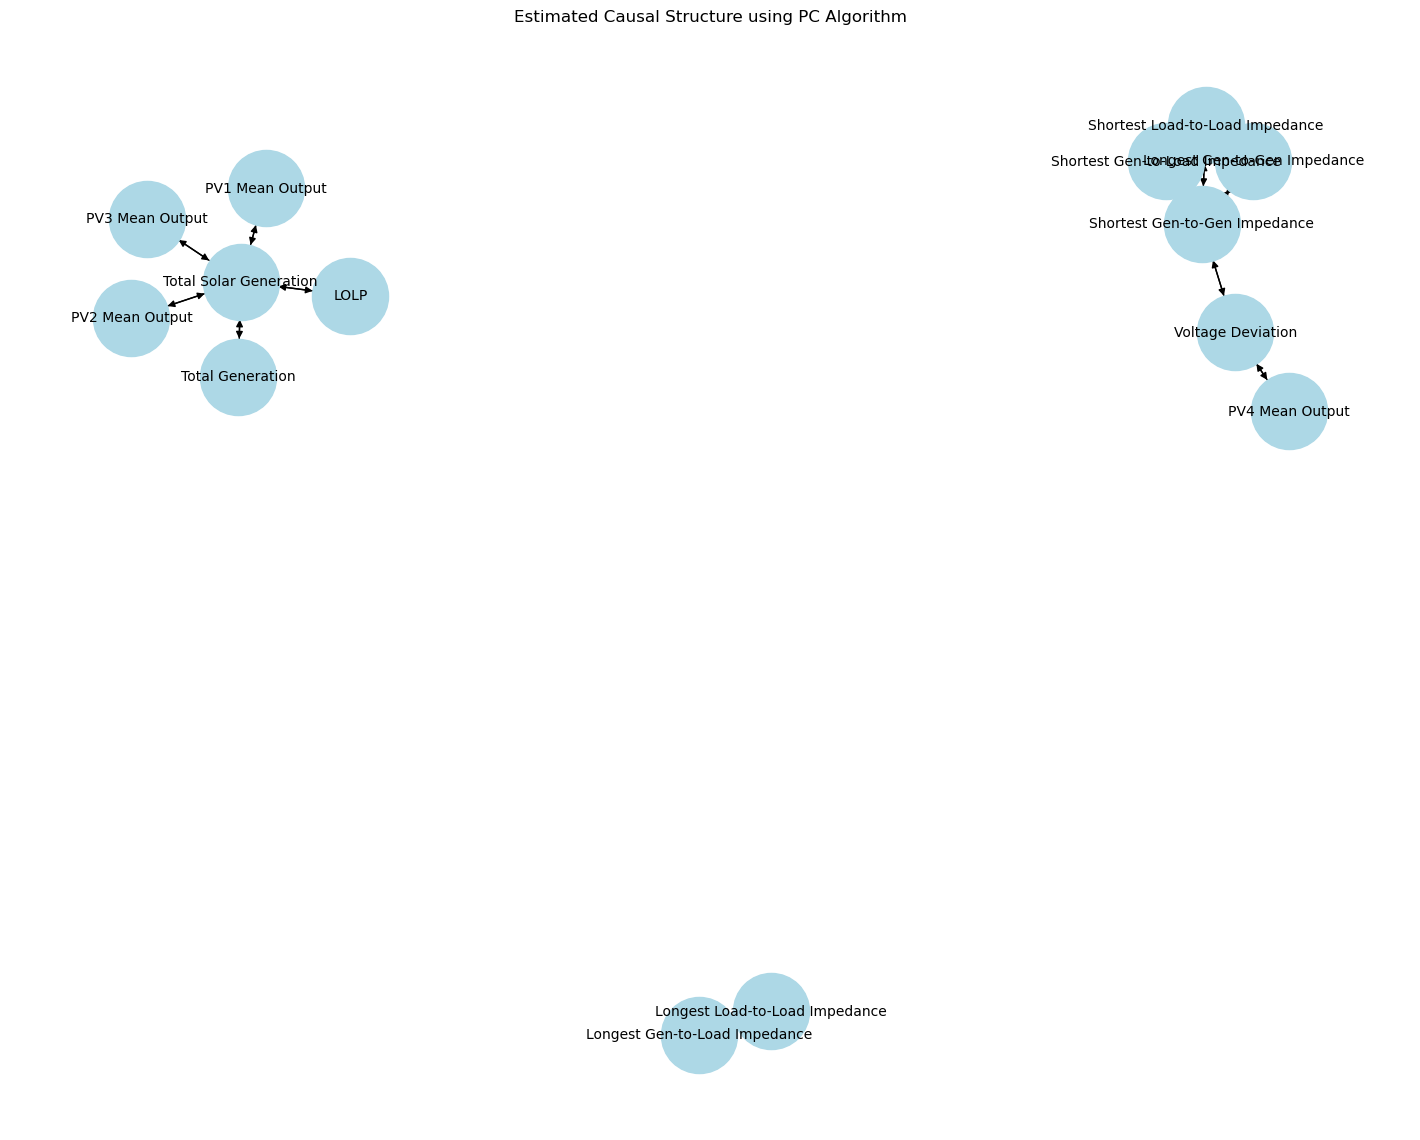

In [108]:
# Standardize the data arrays and create the data object
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_selected), columns=df_selected.columns)

# Apply Peter-Clark Algorithm to Discover Causal Skeleton 
# Which calculates the Partial correlation between any two variables i and j, conditioned on a set of variables k.
print("Running PC Algorithm for Causal Graph Construction...")

pc_alg = pc(df_scaled.to_numpy(), alpha=0.05)  # Conditional Independence test
causal_graph = pc_alg.G

# Convert causal learn graph to NetworkX format
pc_nx_graph = nx.DiGraph() # Skeleton of the Causal graph

# Extract edges and add them to NetworkX graph
for i, j in zip(*np.where(causal_graph.graph != 0)):  
    pc_nx_graph.add_edge(df_selected.columns[i], df_selected.columns[j])  # Add edges using column names

# Draw the causal graph
plt.figure(figsize=(14, 11))
pos = nx.spring_layout(pc_nx_graph)  # Layout for better visualization
nx.draw(pc_nx_graph, pos, with_labels=True, node_color='lightblue', edge_color='black', node_size=3000, font_size=10)
plt.title("Estimated Causal Structure using PC Algorithm")
plt.show()

In [110]:
from __future__ import division
import numpy as np
from scipy.special import psi

def igci(x, y, refMeasure=1, estimator=2):
    """
    Information-Geometric Causal Inference (IGCI) method.

    Parameters:
        x (numpy.ndarray): 1D array representing variable X.
        y (numpy.ndarray): 1D array representing variable Y.
        refMeasure (int): Reference measure for scaling (1: min-max, 2: standardization).
        estimator (int): Estimation method (1: entropy-based, 2: slope-based).

    Returns:
        float: Causal asymmetry score f(x → y), higher values indicate stronger causal direction.
    """

    xi = np.real(x).reshape(-1, 1)
    yi = np.real(y).reshape(-1, 1)

    Lx, dimx = xi.shape
    Ly, dimy = yi.shape

    # ----- Input validation -----
    if dimx != 1 or dimy != 1:
        raise ValueError("Both x and y must be 1D arrays.")

    if Lx < 20 or Ly < 20:
        raise ValueError("Not enough observations in x or y (must be > 20).")

    if Lx != Ly:
        raise ValueError("Lengths of x and y must be equal.")
    # ----------------------------

    # Apply reference measure scaling
    if refMeasure == 1:  # Min-max normalization
        xi = (xi - np.min(xi)) / (np.max(xi) - np.min(xi))
        yi = (yi - np.min(yi)) / (np.max(yi) - np.min(yi))
    elif refMeasure == 2:  # Standardization
        xi = (xi - np.mean(xi)) / np.std(xi)
        yi = (yi - np.mean(yi)) / np.std(yi)
    else:
        print("Warning: Unknown reference measure - no scaling applied.")
        return None

    # ----- Estimation methods -----
    if estimator == 1:
        # Entropy-based estimator
        x1 = np.sort(xi, axis=0)
        y1 = np.sort(yi, axis=0)

        n1 = x1.shape[0]
        hx = np.sum(np.log(np.abs(np.diff(x1)))) / (n1 - 1) + psi(n1) - psi(1)

        n2 = y1.shape[0]
        hy = np.sum(np.log(np.abs(np.diff(y1)))) / (n2 - 1) + psi(n2) - psi(1)

        return hy - hx

    elif estimator == 2:
        # Slope-based estimator
        a, b = 0, 0

        ind1 = np.argsort(xi, axis=0)
        ind2 = np.argsort(yi, axis=0)

        for i in range(Lx - 1):
            # Compute slopes in x → y direction
            X1, X2 = xi[ind1[i, 0], 0], xi[ind1[i + 1, 0], 0]
            Y1, Y2 = yi[ind1[i, 0], 0], yi[ind1[i + 1, 0], 0]
            if (X1 != X2) and (Y1 != Y2):
                a += np.log(np.abs((Y2 - Y1) / (X2 - X1)))

            # Compute slopes in y → x direction
            X1, X2 = xi[ind2[i, 0], 0], xi[ind2[i + 1, 0], 0]
            Y1, Y2 = yi[ind2[i, 0], 0], yi[ind2[i + 1, 0], 0]
            if (X1 != X2) and (Y1 != Y2):
                b += np.log(np.abs((X2 - X1) / (Y2 - Y1)))

        return (a - b) / Lx

    else:
        raise ValueError("Unknown estimator. Use 1 (entropy-based) or 2 (slope-based).")


Applying IGCI Algorithm for Causal Direction...


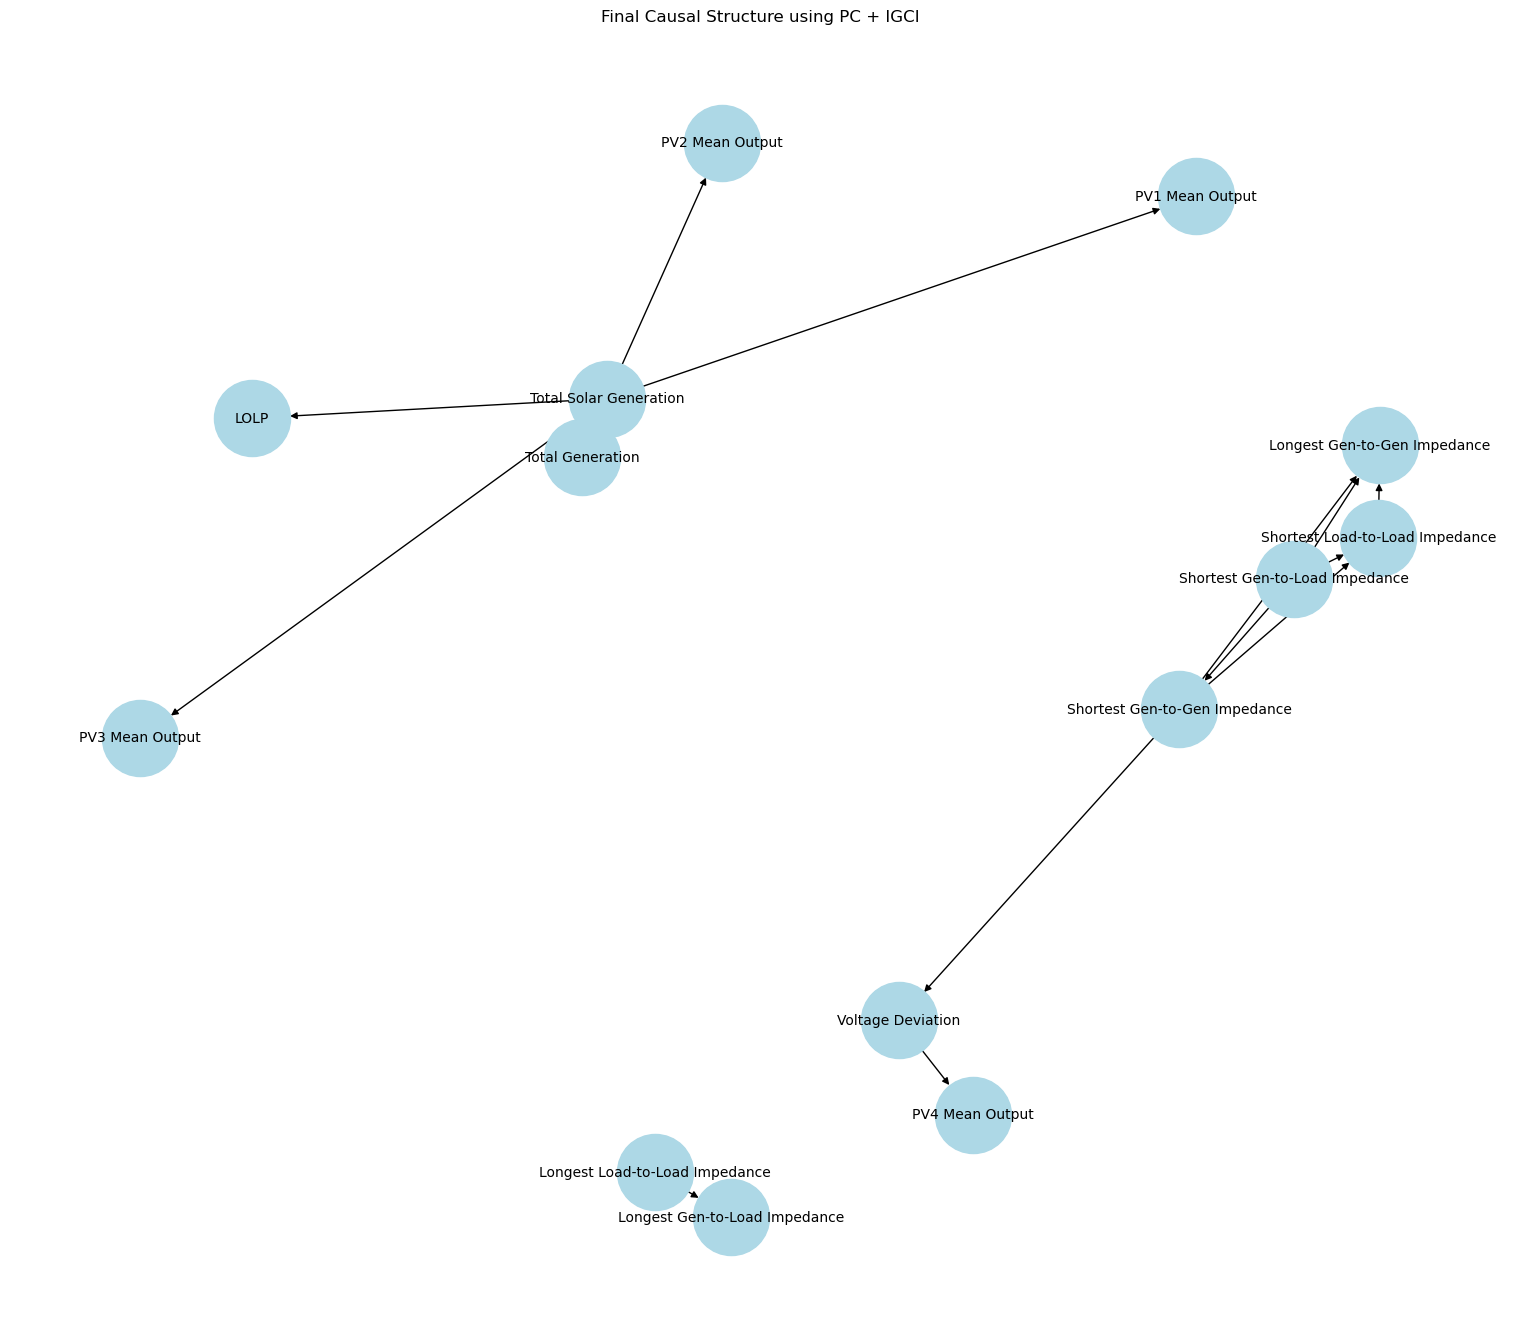

In [116]:
# Apply IGCI for Causal dDrectionality
print("Applying IGCI Algorithm for Causal Direction...")
directed_graph = nx.DiGraph()  # Directed graph after IGCI
for edge in pc_nx_graph.edges():
    var_x, var_y = edge
    x_values = df_scaled[var_x].values
    y_values = df_scaled[var_y].values
    
    # Compute IGCI score
    igci_score = igci(x_values, y_values)  # Implement IGCI scoring method
    if igci_score > 0:  # X → Y
        directed_graph.add_edge(var_x, var_y)
    else:  # Y → X
        directed_graph.add_edge(var_y, var_x)

# Visualize the Final Causal Graph
plt.figure(figsize=(15, 13))
pos = nx.spring_layout(directed_graph)  # Layout for better visualization
nx.draw(directed_graph, pos, with_labels=True, node_color='lightblue', edge_color='black', node_size=3000, font_size=10, arrows=True)
plt.title("Final Causal Structure using PC + IGCI")
plt.show()

### Do-Why Framework: Build the Causal Graph based on Prior and Domain knowledge

In [54]:
# Define causal model
model = CausalModel(
    data=data,
    treatment="Longest Distance (km)",  # Change to "Longest Distance (km)" or "Average Distance (km)" for other treatments
    outcome="LOLP",
    # common_causes=["Total Solar Generation",  "Voltage Deviation"]
)

# Identify and estimate the causal effect
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

print("Causal Effect Estimate:", estimate.value)

Causal Effect Estimate: -0.007296948967221523


In [56]:
# Define causal model
model = CausalModel(
    data=data,
    treatment="Average Distance (km)",  
    outcome="LOLP",
    # common_causes=["Total Solar Generation", "Voltage Deviation"]
)

# Identify and estimate the causal effect
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

print("Causal Effect Estimate:", estimate.value)

Causal Effect Estimate: -0.013581205457296602


### The Causal effect of Varaiation of the Reactive power capacity on Network Reliability

In [ ]:
# Load and the 30-bus reinforce network
net = pn.case30()
net = reinforce_network(net)

# Define PV buses
pv_buses = [1, 21, 26, 22, 12]

# Fixed means and standard deviations for injected power
pv_bus_means = [20.42496, 12.76560, 14.04216, 7.65936, 10.21248]
pv_bus_stds = [25.622111, 16.013819, 17.615201, 9.608292, 12.811055]

# Define base reactive power capacities
base_min_q = [-20.0, -15.0, -15.0, -10.0, -15.0]
base_max_q = [60.0, 62.5, 48.7, 40.0, 44.7]

# Reactive power variability (normal distribution parameters)
min_q_mean_variation = 0.1  # ±10% of base min_q
max_q_mean_variation = 0.1  # ±10% of base max_q
std_dev_factor = 0.05  # Std dev as a fraction of mean

In [ ]:
# Number of scenarios and Monte Carlo runs
n_scenarios = 100
n_runs_per_scenario = 500
# Results storage
scenario_results = []

In [ ]:
# Generate scenarios
for scenario in range(n_scenarios):
    print(f"Running Scenario {scenario + 1}/{n_scenarios}")
    lolp_count = 0
    total_solar_generation = []
    total_reactive_power = []
    voltage_deviations = []
    
    # Adjust reactive power capacities for this scenario
    scenario_min_q = [np.random.normal(min_q * (1 + np.random.uniform(-min_q_mean_variation, min_q_mean_variation)), 
                                       abs(min_q * std_dev_factor)) for min_q in base_min_q]
    scenario_max_q = [np.random.normal(max_q * (1 + np.random.uniform(-max_q_mean_variation, max_q_mean_variation)), 
                                       abs(max_q * std_dev_factor)) for max_q in base_max_q]
    
    for run in range(n_runs_per_scenario):
        # Sample PV outputs from the normal distribution
        pv_outputs = [max(0, np.random.normal(mean, std)) for mean, std in zip(pv_bus_means, pv_bus_stds)]
       # Update PV generation in the network
        for i, bus in enumerate(pv_buses):
            if bus in net.sgen['bus'].values:
                net.sgen.loc[net.sgen['bus'] == bus, 'p_mw'] = pv_outputs[i]
            else:
                pp.create_sgen(net, bus, p_mw=pv_outputs[i], name=f"PV_bus_{bus}")
        
        # Update reactive power capacities
        for i, bus in enumerate(pv_buses):
            net.gen.loc[net.gen['bus'] == bus, 'min_q_mvar'] = scenario_min_q[i]
            net.gen.loc[net.gen['bus'] == bus, 'max_q_mvar'] = scenario_max_q[i]
        
        try:
            # Run power flow
            pp.runpp(net)
            
            # Calculate metrics
            total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
            total_solar_generation.append(net.res_sgen['p_mw'].sum())
            total_reactive_power.append(net.res_bus['q_mvar'].sum())
            voltage_deviation = np.mean(abs(net.res_bus['vm_pu'] - 1.0))
            voltage_deviations.append(voltage_deviation)
            
            # Calculate LOLP
            total_load = net.load['p_mw'].sum()
            if total_generation < total_load:
                lolp_count += 1
        except pp.LoadflowNotConverged:
            print(f"Loadflow did not converge for Scenario {scenario + 1}, Run {run + 1}.")
            continue
    # Calculate scenario metrics
    avg_lolp = lolp_count / n_runs_per_scenario
    print(f"Scenario {scenario + 1}: Average LOLP = {avg_lolp}")
    avg_solar_generation = np.mean(total_solar_generation)
    avg_reactive_power = np.mean(total_reactive_power)
    avg_voltage_deviation = np.mean(voltage_deviations)
    
    # Record scenario results
    scenario_results.append({
        'Scenario': scenario + 1,
        'Min Q (PV1)': scenario_min_q[0],
        'Max Q (PV1)': scenario_max_q[0],
        'Min Q (PV2)': scenario_min_q[1],
        'Max Q (PV2)': scenario_max_q[1],
        'Min Q (PV3)': scenario_min_q[2],
        'Max Q (PV3)': scenario_max_q[2],
        'Min Q (PV4)': scenario_min_q[3],
        'Max Q (PV4)': scenario_max_q[3],
        'Min Q (PV5)': scenario_min_q[4],
        'Max Q (PV5)': scenario_max_q[4],
        'Total Solar Generation': avg_solar_generation,
        'Total Reactive Power': avg_reactive_power,
        'Voltage Deviation': avg_voltage_deviation,
        'LOLP': avg_lolp
    })

# Save results to a DataFrame
df_scenario_results = pd.DataFrame(scenario_results)
df_scenario_results.to_excel("reactive_power_scenarios.xlsx", index=False)
print("Scenario results saved to 'reactive_power_scenarios.xlsx'.")

In [ ]:
data = pd.read_excel("reactive_power_scenarios.xlsx")
# View data structure
print(data.head())

In [ ]:
pv_buses = ['Min Q (PV1)', 'Max Q (PV1)', 'Min Q (PV2)', 'Max Q (PV2)',
            'Min Q (PV3)', 'Max Q (PV3)', 'Min Q (PV4)', 'Max Q (PV4)',
            'Min Q (PV5)', 'Max Q (PV5)']

# Loop through each PV bus feature
for pv_bus in pv_buses:
    print(f"Analyzing causal effect for treatment: {pv_bus}")
    
    # Create the CausalModel
    model = CausalModel(
        data=data,
        treatment=pv_bus,  # Reactive power capacity of the current PV bus
        outcome='LOLP',  # Outcome variable
        common_causes=['Voltage Deviation']  # Known confounders
    )
    
    # Visualize the DAG
    model.view_model()  #  generate the DAG 
    
    # Identify the causal effect
    identified_estimand = model.identify_effect()
    #print("Identified Estimand:", identified_estimand)
    
    # Estimate the causal effect
    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"  # Suitable for continuous treatments
    )
    
    # Print the causal effect estimate
    print(f"Causal Effect Estimate for {pv_bus}: {causal_estimate.value}")
    print("-" * 50)


## Exploring Impedance Distance and Grid Reliability 
The causal effect of variations in impedance distance (transmission line characteristics) on the reliability of the power grid.

In [ ]:
# Load and the 30-bus reinforce network
net = pn.case30()
net = reinforce_network(net)

In [ ]:
# Define PV buses
pv_buses = [1, 21, 26, 22, 12]

# Fixed means and standard deviations for injected power
pv_bus_means = [20.42496, 12.76560, 14.04216, 7.65936, 10.21248]
pv_bus_stds = [25.622111, 16.013819, 17.615201, 9.608292, 12.811055]

# Inspect the transmission line characteristics #Resistance Reactance Capacitance per kilometer per kilometer
print(net.line[['from_bus', 'to_bus', 'length_km', 'r_ohm_per_km', 'x_ohm_per_km', 'c_nf_per_km']])

In [ ]:
n_topologies = 100  # Number of grid topologies
n_runs_per_scenario = 500
# Create a list to store results
topology_results = []

# Function to calculate impedance distance
def calculate_impedance_distance(net):
    return np.sum(np.sqrt(net.line['r_ohm_per_km']**2 + net.line['x_ohm_per_km']**2) * net.line['length_km'])

# Generate different topologies by varying line impedances
for topology in range(n_topologies):
    print(f"Running Topology {topology + 1}/{n_topologies}")
    lolp_count = 0
    voltage_deviations = []
    total_generations = []
    
    # Introduce random variations in line impedances
    net.line['r_ohm_per_km'] = net.line['r_ohm_per_km'] * (1 + np.random.uniform(-0.2, 0.2, size=len(net.line)))
    net.line['x_ohm_per_km'] = net.line['x_ohm_per_km'] * (1 + np.random.uniform(-0.2, 0.2, size=len(net.line)))
    
    # Calculate the impedance distance for this topology
    impedance_distance = calculate_impedance_distance(net)
    
    # Run stochastic simulations to calculate reliability metrics    
    for run in range(n_runs_per_scenario):  # Monte Carlo runs per topology
        try:
            # Sample PV outputs from the normal distribution
            pv_outputs = [max(0, np.random.normal(mean, std)) for mean, std in zip(pv_bus_means, pv_bus_stds)]
            # Update PV generation in the network
            for i, bus in enumerate(pv_buses):
                if bus in net.sgen['bus'].values:
                    net.sgen.loc[net.sgen['bus'] == bus, 'p_mw'] = pv_outputs[i]
                else:
                    pp.create_sgen(net, bus, p_mw=pv_outputs[i], name=f"PV_bus_{bus}")
                    
            # Run power flow
            pp.runpp(net)
            
            # Calculate metrics
            total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
            total_load = net.load['p_mw'].sum()
            
            # Calculate LOLP
            if total_generation < total_load:
                lolp_count += 1
            
            # Voltage deviation
            voltage_deviation = np.mean(abs(net.res_bus['vm_pu'] - 1.0))
            voltage_deviations.append(voltage_deviation)
            total_generations.append(total_generation)
        
        except pp.LoadflowNotConverged:
            print(f"Loadflow did not converge for Topology {topology + 1}, Run {run + 1}.")
            continue
    
    # Average metrics for this topology
    avg_lolp = lolp_count / n_runs_per_scenario
    print(f"Scenario {topology + 1}: Average LOLP = {avg_lolp}")
    avg_voltage_deviation = np.mean(voltage_deviations)
    avg_total_generation = np.mean(total_generations)
    mean_impedance_distance = impedance_distance
    
    # Store results
    topology_results.append({
        'Topology': topology + 1,
        'Average LOLP': avg_lolp,
        'Impedance Distance': mean_impedance_distance,
        'Voltage Deviation': avg_voltage_deviation,
        'Average Total Generation': avg_total_generation
    })

# Save results to an Excel file
df_topology_results = pd.DataFrame(topology_results)
df_topology_results.to_excel("topology_reliability_results.xlsx", index=False)
print("Topology results saved to 'topology_reliability_results.xlsx'.")

In [ ]:
# Load the results
data = pd.read_excel("topology_reliability_results.xlsx")
# View data structure
print(data.head())

In [ ]:
# Define the causal model
model = CausalModel(
    data=data,
    treatment="Impedance Distance",  # Proxy for impedance distance
    outcome="Average LOLP",
    common_causes=["Voltage Deviation"]  # Confounders
)
    # Visualize the DAG
model.view_model()  #  generate the DAG 
# Identify and estimate the causal effect
identified_estimand = model.identify_effect()
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("Causal Effect Estimate:", causal_estimate.value)